In [1]:
import pandas as pd
import numpy as np
import re
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import random
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

c:\Users\Sultan\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [2]:
def clean_text(text):
    if pd.isna(text):
        return ""
    
    text = str(text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    text = re.sub(r'\s+', ' ', text)
    return text.lower().strip()


In [3]:
df = pd.read_csv("data_prelabeled_full.csv")

df = df.dropna(subset=['aspect', 'context', 'polaritas'])

df['aspect_clean'] = df['aspect'].apply(clean_text)
df['context_clean'] = df['context'].apply(clean_text)

df['polaritas'] = df['polaritas'].str.lower().str.strip()

label_map = {'negatif':0, 'negative':0, 'netral':1, 'neutral':1, 'positif':2, 'positive':2}
inv_label_map = {0:'negatif', 1:'netral', 2:'positif'}

df['label'] = df['polaritas'].map(label_map)

df['text'] = df['aspect_clean'] + " [SEP] " + df['context_clean']

df = df[df['text'].str.strip() != ""]

print("\n" + "="*80)
print("CONTOH FORMAT INPUT UNTUK MODEL")
print("="*80)
for i in range(3):
    print(f"\nContoh {i+1}:")
    print(f"Aspek: {df.iloc[i]['aspect']}")
    print(f"Konteks: {df.iloc[i]['context']}")
    print(f"Format Input: {df.iloc[i]['text']}")
    print(f"Label: {df.iloc[i]['polaritas']}")


CONTOH FORMAT INPUT UNTUK MODEL

Contoh 1:
Aspek: Aplikasi
Konteks: saat di lapangan tidak seindah saat di aplikasi terimakasih
Format Input: aplikasi [SEP] saat di lapangan tidak seindah saat di aplikasi terimakasih
Label: negatif

Contoh 2:
Aspek: Pembayaran
Konteks: sudah bayar di app presisi logo biru, sekarang ganti jadi oren malah ilang semua yang kemarin udah ngisi profile dan bayar
Format Input: pembayaran [SEP] sudah bayar di app presisi logo biru sekarang ganti jadi oren malah ilang semua yang kemarin udah ngisi profile dan bayar
Label: negatif

Contoh 3:
Aspek: Aplikasi
Konteks: sudah bayar di app presisi logo biru, sekarang ganti jadi oren malah ilang semua yang kemarin udah ngisi profile dan bayar
Format Input: aplikasi [SEP] sudah bayar di app presisi logo biru sekarang ganti jadi oren malah ilang semua yang kemarin udah ngisi profile dan bayar
Label: negatif


In [4]:
print("\n" + "="*80)
print("STATISTIK POLARITAS PER ASPEK")
print("="*80)

aspek_list = ["aplikasi", "kemudahan", "pembayaran"]

for aspek in aspek_list:
    print(f"\n>>> Aspek: {aspek.upper()}")
    aspek_df = df[df['aspect_clean'].str.contains(aspek, na=False)]
    
    if len(aspek_df) == 0:
        print("Tidak ada data.")
        continue

    print(aspek_df['label'].map(inv_label_map).value_counts())


STATISTIK POLARITAS PER ASPEK

>>> Aspek: APLIKASI
label
negatif    1272
positif     157
netral       35
Name: count, dtype: int64

>>> Aspek: KEMUDAHAN
label
negatif    542
positif    117
netral      13
Name: count, dtype: int64

>>> Aspek: PEMBAYARAN
label
negatif    709
positif     58
netral      21
Name: count, dtype: int64


In [5]:
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)


In [6]:
MODEL_NAME = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class ABSADataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        enc = tokenizer(
            self.texts[idx],
            max_length=128,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": enc["input_ids"].flatten(),
            "attention_mask": enc["attention_mask"].flatten(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = ABSADataset(train_df["text"].tolist(), train_df["label"].tolist())
test_dataset = ABSADataset(test_df["text"].tolist(), test_df["label"].tolist())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=16)


In [7]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    ignore_mismatched_sizes=True
).to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
def train_epoch(model, dataloader, optimizer, scheduler):
    model.train()
    total, correct, total_loss = 0, 0, 0
    
    for batch in tqdm(dataloader, desc="Training"):
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        out = model(input_ids=ids, attention_mask=mask, labels=labels)

        loss = out.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        pred = out.logits.argmax(1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(dataloader), correct / total


def eval_model(model, dataloader):
    model.eval()
    preds, trues = [], []
    losses = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            out = model(input_ids=ids, attention_mask=mask, labels=labels)
            losses += out.loss.item()
            preds.extend(out.logits.argmax(1).cpu().numpy())
            trues.extend(labels.cpu().numpy())

    acc = accuracy_score(trues, preds)
    return losses / len(dataloader), acc, preds, trues


In [9]:
EPOCHS = 3
optimizer = AdamW(model.parameters(), lr=3e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0,
    num_training_steps=len(train_loader) * EPOCHS
)

best_train_acc = 0
best_epoch = 0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler)
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    
    # Bandingkan training accuracy dengan yang terbaik
    if train_acc > best_train_acc:
        best_train_acc = train_acc
        best_epoch = epoch + 1
        torch.save(model.state_dict(), "best_indobert_absa_augmented.pt")
        print(f"✅ Model terbaik disimpan! Train Accuracy: {train_acc:.4f} (Epoch {best_epoch})")
    else:
        print(f"❌ Model tidak disimpan. Train accuracy terbaik: {best_train_acc:.4f} (Epoch {best_epoch})")

print(f"\n🎯 Training selesai! Best train accuracy: {best_train_acc:.4f} pada epoch {best_epoch}")


Epoch 1/3


Training:  46%|████▋     | 68/147 [17:44<20:36, 15.66s/it]


KeyboardInterrupt: 

In [ ]:
model.load_state_dict(torch.load("best_indobert_absa_augmented.pt"))

test_loss, test_acc, preds, trues = eval_model(model, test_loader)

print("\nTEST RESULTS")
print("Test Loss:", test_loss)
print("Test Acc:", test_acc)

print(classification_report(trues, preds, target_names=['negatif','netral','positif']))


Evaluating: 100%|██████████| 37/37 [03:19<00:00,  5.39s/it]


TEST RESULTS
Test Loss: 0.31321414469464404
Test Acc: 0.9076923076923077
              precision    recall  f1-score   support

     negatif       0.94      0.97      0.95       505
      netral       1.00      0.14      0.25        14
     positif       0.63      0.62      0.63        66

    accuracy                           0.91       585
   macro avg       0.86      0.58      0.61       585
weighted avg       0.91      0.91      0.90       585



In [ ]:
def analyze_per_aspect(test_df, predictions):
    """Analisis akurasi per aspek untuk debugging"""
    test_df_copy = test_df.copy()
    test_df_copy['predicted'] = predictions
    test_df_copy['predicted_label'] = test_df_copy['predicted'].map(inv_label_map)
    test_df_copy['true_label'] = test_df_copy['label'].map(inv_label_map)
    
    print("\n" + "="*80)
    print("ANALISIS AKURASI PER ASPEK")
    print("="*80)
    
    aspek_list = ["aplikasi", "kemudahan", "pembayaran"]
    
    for aspek in aspek_list:
        aspek_df = test_df_copy[test_df_copy['aspect_clean'].str.contains(aspek, na=False)]
        
        if len(aspek_df) == 0:
            continue
            
        correct = (aspek_df['label'] == aspek_df['predicted']).sum()
        total = len(aspek_df)
        accuracy = correct / total
        
        print(f"\n{'='*60}")
        print(f">>> Aspek: {aspek.upper()}")
        print(f"{'='*60}")
        print(f"Total data test: {total}")
        print(f"Prediksi benar: {correct}")
        print(f"Prediksi salah: {total - correct}")
        print(f"Akurasi: {accuracy:.2%}")
        
        # Lihat distribusi prediksi
        print(f"\nDistribusi Prediksi:")
        print(aspek_df['predicted_label'].value_counts())
        
        # Classification report
        print(f"\nClassification Report untuk {aspek.upper()}:")
        print(classification_report(
            aspek_df['label'], 
            aspek_df['predicted'],
            target_names=['negatif','netral','positif'],
            zero_division=0
        ))
        
        # Tampilkan beberapa contoh salah prediksi
        wrong_pred = aspek_df[aspek_df['label'] != aspek_df['predicted']]
        if len(wrong_pred) > 0:
            print(f"\nContoh Kesalahan Prediksi (max 5):")
            for i, row in wrong_pred.head(5).iterrows():
                print(f"\n  • Aspek: {row['aspect']}")
                print(f"    Konteks: {row['context'][:80]}...")
                print(f"    True: {row['true_label']} | Predicted: {row['predicted_label']}")

# Jalankan analisis
analyze_per_aspect(test_df, preds)

In [ ]:
def check_random_predictions(test_df, predictions, num_samples=15):
    """Cek prediksi random untuk masing-masing aspek"""
    test_df_copy = test_df.copy()
    test_df_copy['predicted'] = predictions
    test_df_copy['predicted_label'] = test_df_copy['predicted'].map(inv_label_map)
    test_df_copy['true_label'] = test_df_copy['label'].map(inv_label_map)
    
    print("\n" + "="*80)
    print("SAMPLE PREDIKSI PER ASPEK")
    print("="*80)
    
    aspek_list = ["aplikasi", "kemudahan", "pembayaran"]
    
    for aspek in aspek_list:
        aspek_df = test_df_copy[test_df_copy['aspect_clean'].str.contains(aspek, na=False)]
        
        if len(aspek_df) == 0:
            continue
            
        print(f"\n{'='*60}")
        print(f">>> Aspek: {aspek.upper()}")
        print(f"{'='*60}")
        
        # Ambil sample random
        samples = aspek_df.sample(min(num_samples, len(aspek_df)))
        
        for idx, row in samples.iterrows():
            status = "✓ BENAR" if row['label'] == row['predicted'] else "✗ SALAH"
            print(f"\n  {status}")
            print(f"  Aspek: {row['aspect']}")
            print(f"  Konteks: {row['context'][:80]}...")
            print(f"  True: {row['true_label']} | Predicted: {row['predicted_label']}")

# Jalankan
check_random_predictions(test_df, preds, 10)

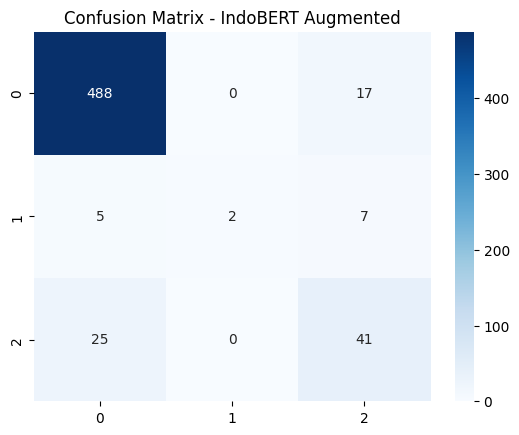

In [ ]:
cm = confusion_matrix(trues, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - IndoBERT Augmented")
plt.savefig("confusion_matrix_augmented.png")
plt.show()

test_df_copy = test_df.copy()
test_df_copy['predicted'] = preds
test_df_copy['predicted_label'] = test_df_copy['predicted'].map(inv_label_map)
test_df_copy.to_csv("test_predictions_augmented.csv", index=False)


In [ ]:
test_df_copy = test_df.copy()
test_df_copy['predicted'] = preds
test_df_copy['predicted_label'] = test_df_copy['predicted'].map(inv_label_map)
test_df_copy['true_label'] = test_df_copy['label'].map(inv_label_map)
test_df_copy['is_correct'] = (test_df_copy['label'] == test_df_copy['predicted'])

# Simpan hasil lengkap
test_df_copy.to_csv("test_predictions_detailed.csv", index=False)

# Simpan hanya yang salah prediksi untuk analisis
wrong_predictions = test_df_copy[~test_df_copy['is_correct']]
wrong_predictions.to_csv("test_predictions_errors.csv", index=False)

print(f"\n✓ Saved detailed results to test_predictions_detailed.csv")
print(f"✓ Saved error analysis to test_predictions_errors.csv")